# Homework 3
## December 7, 2020
## Anderson Monken

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow_datasets as tfds
import datetime
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
tfkl = tfk.layers

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Question 1

#### Load cifar10 dataset and see its information. Noting the size of the input image and the label output structure.

In [3]:
data, info = tfds.load('cifar10', with_info = True)

In [4]:
info

tfds.core.DatasetInfo(
    name='cifar10',
    version=3.0.2,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    redistribution_info=,
)

In [5]:
img_shape = info.features['image'].shape
print(f'image dimensions: {img_shape}')

image dimensions: (32, 32, 3)


#### Preprocess the data and see some what some of the images look like

In [6]:
preprocess = lambda d: (tf.cast(d["image"], tf.float32)/255., 
                        tf.one_hot(d["label"], depth=10))
ae_targets = lambda x, y: (x, x)

ds_train = (data["train"]
            .map(preprocess)
            .map(ae_targets)
            .batch(128)
            .cache()
            .repeat()
            .prefetch(128)
           )

ds_test = (data["test"]
           .map(preprocess)
           .map(ae_targets)
           .batch(128)
           .cache()
           .repeat()
           .prefetch(128)
          )

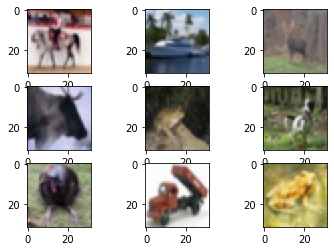

In [7]:
x, y = next(iter(ds_train))

# plot first few images
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x[i,:,:,:])
    #plt.title(np.argmax(y[i].numpy()))
# show the figure
plt.show()

#### Define the model architecture and fit the model

In [8]:
encoder = tfk.Sequential([
  tfkl.InputLayer(img_shape),
  tfkl.Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
  tfkl.MaxPooling2D((2,2), padding = 'same'),
  tfkl.Dropout(0.02),
  tfkl.Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
  tfkl.MaxPooling2D((2,2), padding = 'same'),
  tfkl.Dropout(0.02), 
])
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 128)       3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 64)          0         
Total params: 77,376
Trainable params: 77,376
Non-trainable params: 0
____________________________________________________

In [9]:
decoder = tfk.Sequential([
  tfkl.InputLayer(encoder.output.shape[1:]),
  tfkl.Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
  tfkl.UpSampling2D((2,2)),
  tfkl.Dropout(0.02),
  tfkl.Conv2D(32, (3,3), activation = 'relu', padding = 'same'),
  tfkl.UpSampling2D((2,2)),
  tfkl.Dropout(0.02),
  tfkl.Conv2D(32, (3,3), activation = 'relu', padding = 'same'),
  tfkl.Dropout(0.02),
  tfkl.Conv2D(3, (3,3), activation = 'sigmoid', padding = 'same')
])
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        18464     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)       

#### Set up the encoder decoder process

In [10]:
x = tfkl.Input(img_shape)
h = encoder(x)
xhat = decoder(h)
h, xhat

(<tf.Tensor 'sequential/dropout_1/cond/Identity:0' shape=(None, 8, 8, 64) dtype=float32>,
 <tf.Tensor 'sequential_1/conv2d_5/Sigmoid:0' shape=(None, 32, 32, 3) dtype=float32>)

In [11]:
autoencoder = tfk.Model(inputs=x, outputs=xhat)
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 8, 8, 64)          77376     
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 3)         65507     
Total params: 142,883
Trainable params: 142,883
Non-trainable params: 0
_________________________________________________________________


In [12]:
# training happens as usual
autoencoder.compile(
    optimizer=tfk.optimizers.Adam(),
    loss=tfk.losses.MeanSquaredError(),
)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

results = autoencoder.fit(ds_train, steps_per_epoch=250, epochs=20, 
                          validation_data = ds_test,
                          validation_steps = 1,
          callbacks=[tensorboard_callback])

Epoch 1/20
  1/250 [..............................] - ETA: 0s - loss: 0.0648WARNING:tensorflow:From /opt/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


Instructions for updating:
use `tf.profiler.experimental.stop` instead.


  2/250 [..............................] - ETA: 7s - loss: 0.0644WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0075s vs `on_train_batch_end` time: 0.0518s). Check your callbacks.


250/250 [==============================] - 3s 12ms/step - loss: 0.0135 - val_loss: 0.0064
Epoch 2/20
250/250 [==============================] - 3s 11ms/step - loss: 0.0057 - val_loss: 0.0041
Epoch 3/20
250/250 [==============================] - 3s 10ms/step - loss: 0.0047 - val_loss: 0.0035
Epoch 4/20
250/250 [==============================] - 3s 10ms/step - loss: 0.0042 - val_loss: 0.0032
Epoch 5/20
250/250 [==============================] - 3s 10ms/step - loss: 0.0039 - val_loss: 0.0029
Epoch 6/20
250/250 [==============================] - 3s 10ms/step - loss: 0.0036 - val_loss: 0.0028
Epoch 7/20
250/250 [==============================] - 3s 10ms/step - loss: 0.0034 - val_loss: 0.0026
Epoch 8/20
250/250 [==============================] - 3s 10ms/step - loss: 0.0032 - val_loss: 0.0024
Epoch 9/20
250/250 [==============================] - 3s 10ms/step - loss: 0.0031 - val_loss: 0.0023
Epoch 10/20
250/250 [==============================] - 3s 10ms/step - loss: 0.0030 - val_loss: 0.0022


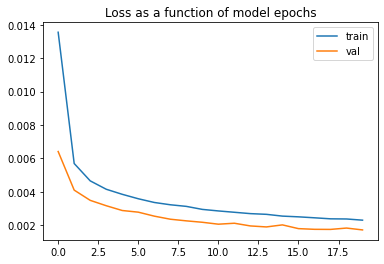

In [13]:
plt.plot(results.history["loss"])
plt.plot(results.history["val_loss"])
plt.legend(labels=["train", "val"])
plt.title("Loss as a function of model epochs")

plt.show()

In [14]:
imgs = next(iter(ds_train))[0]

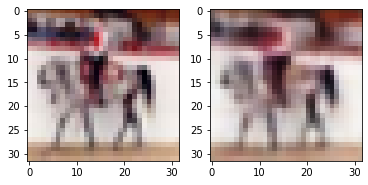

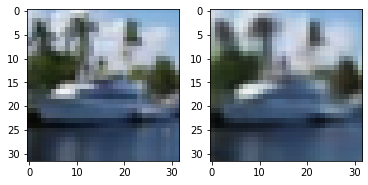

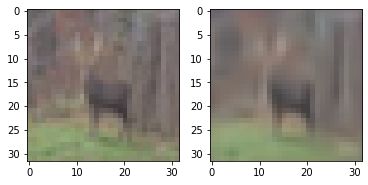

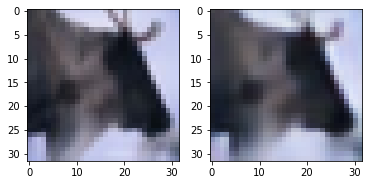

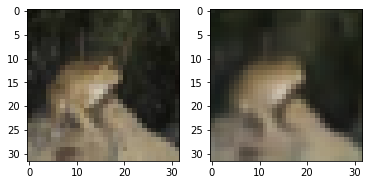

In [15]:
for i in range(5):
  plt.subplot(1, 2, 1)
  plt.imshow(imgs[i].numpy().squeeze(), cmap='bone')
  plt.subplot(1, 2, 2, )
  plt.imshow(autoencoder(imgs[i][tf.newaxis]).numpy().squeeze(), cmap='bone')
  plt.show()

# Question 2

In [16]:
preprocess = lambda d: (tf.cast(d["image"], tf.float32)/255., 
                        tf.one_hot(d["label"], depth=10))

ds_train = (data["train"]
            .map(preprocess)
            .batch(128)
            .cache()
            .repeat()
            .prefetch(128)
           )

ds_test = (data["test"]
           .map(preprocess)
           .batch(128)
           .cache()
           .repeat()
           .prefetch(128)
          )

In [17]:
model = tfk.Sequential()
# 1st conv module
model.add(tfkl.Conv2D(filters = 256, kernel_size=(2,2), strides=(1,1), 
                      padding="same", activation='relu', input_shape=img_shape))
model.add(tfkl.AveragePooling2D(pool_size=(2,2)))
model.add(tfkl.Dropout(0.25))

# 2nd conv module
model.add(tfkl.Conv2D(filters = 256, kernel_size=2, strides=(1,1), 
                      padding="same", activation='relu'))
model.add(tfkl.AveragePooling2D(pool_size=(2,2)))
model.add(tfkl.Dropout(0.25))

# 3rd conv module
model.add(tfkl.Conv2D(filters = 256, kernel_size=(2,2), strides=(1,1), 
                      padding="valid", activation='relu'))
model.add(tfkl.AveragePooling2D(pool_size=(2,2)))
model.add(tfkl.Dropout(0.25))

model.add(tfkl.Flatten())
model.add(tfkl.Dense(64, activation='relu'))
model.add(tfkl.Dense(10, activation='softmax'))

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 256)       3328      
_________________________________________________________________
average_pooling2d (AveragePo (None, 16, 16, 256)       0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 256)       262400    
_________________________________________________________________
average_pooling2d_1 (Average (None, 8, 8, 256)         0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 256)        

In [19]:
model.compile(
    optimizer=tfk.optimizers.Adam(),
    loss=tfk.losses.CategoricalCrossentropy(),
    metrics=[tfk.metrics.CategoricalAccuracy()]
)

results = model.fit(ds_train, 
                    epochs=20,
                    steps_per_epoch=1000, 
                    validation_data=ds_test, 
                    validation_steps = 1)

Epoch 1/20
1000/1000 [==============================] - 15s 15ms/step - loss: 1.4624 - categorical_accuracy: 0.4717 - val_loss: 1.2012 - val_categorical_accuracy: 0.6172
Epoch 2/20
1000/1000 [==============================] - 15s 15ms/step - loss: 1.0762 - categorical_accuracy: 0.6203 - val_loss: 1.0249 - val_categorical_accuracy: 0.6562
Epoch 3/20
1000/1000 [==============================] - 15s 15ms/step - loss: 0.9213 - categorical_accuracy: 0.6774 - val_loss: 0.8548 - val_categorical_accuracy: 0.6797
Epoch 4/20
1000/1000 [==============================] - 15s 15ms/step - loss: 0.8195 - categorical_accuracy: 0.7140 - val_loss: 0.8066 - val_categorical_accuracy: 0.7266
Epoch 5/20
1000/1000 [==============================] - 15s 15ms/step - loss: 0.7376 - categorical_accuracy: 0.7412 - val_loss: 0.7306 - val_categorical_accuracy: 0.7578
Epoch 6/20
1000/1000 [==============================] - 15s 15ms/step - loss: 0.6778 - categorical_accuracy: 0.7628 - val_loss: 0.6736 - val_categoric

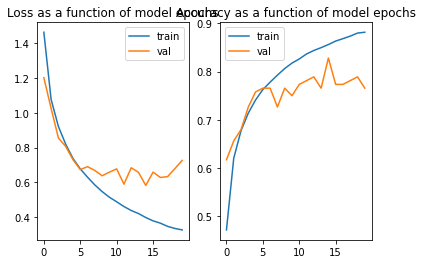

In [20]:
plt.subplot(1,2,1)
plt.plot(results.history["loss"])
plt.plot(results.history["val_loss"])
plt.legend(labels=["train", "val"])
plt.title("Loss as a function of model epochs")

plt.subplot(1,2,2)
plt.plot(results.history["categorical_accuracy"])
plt.plot(results.history["val_categorical_accuracy"])
plt.legend(labels=["train", "val"])
plt.title("Accuracy as a function of model epochs")
plt.show()

### Part 2 - transfer learning

I tried used VGG19, thinking that the larger model would be able to describe the data better. But the additional complexity of parameters (5 million more) led to more training time, and low training efficiency compared to the home-made model. I moved back to VGG16 and found better results.

Going from the 512 output parameters from VGG16 to the final dense layer of 10 nodes with softmax, turned out to be a poor learner. By adding one additional intermediate sized layer, the model trained much more efficiently. Overall though, the performance of transfer learning did not do as well in this task as the homegrown model did.

In [21]:
from tensorflow.keras.applications import VGG16

In [22]:
conv_base = VGG16(weights="imagenet",include_top=False,input_shape=img_shape)

In [23]:
conv_base.trainable = False
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [24]:
model = tfk.Sequential()
model.add(conv_base)
model.add(tfkl.Flatten())
model.add(tfkl.Dense(64, activation='relu'))
model.add(tfkl.Dense(10, activation='softmax'))

In [25]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 14,748,170
Trainable params: 33,482
Non-trainable params: 14,714,688
_________________________________________________________________


In [26]:
model.compile(
    optimizer=tfk.optimizers.RMSprop(),
    loss=tfk.losses.CategoricalCrossentropy(),
    metrics=[tfk.metrics.CategoricalAccuracy()]
)

results = model.fit(ds_train, 
                    steps_per_epoch=2000,
                    epochs=10,
                    validation_data=ds_test, 
                    validation_steps = 1)

Epoch 1/10
2000/2000 [==============================] - 16s 8ms/step - loss: 1.2578 - categorical_accuracy: 0.5635 - val_loss: 1.1946 - val_categorical_accuracy: 0.5547
Epoch 2/10
2000/2000 [==============================] - 15s 8ms/step - loss: 1.1053 - categorical_accuracy: 0.6157 - val_loss: 1.1636 - val_categorical_accuracy: 0.5234
Epoch 3/10
2000/2000 [==============================] - 15s 8ms/step - loss: 1.0527 - categorical_accuracy: 0.6347 - val_loss: 1.1268 - val_categorical_accuracy: 0.5703
Epoch 4/10
2000/2000 [==============================] - 15s 8ms/step - loss: 1.0165 - categorical_accuracy: 0.6482 - val_loss: 1.1357 - val_categorical_accuracy: 0.5859
Epoch 5/10
2000/2000 [==============================] - 15s 8ms/step - loss: 0.9867 - categorical_accuracy: 0.6589 - val_loss: 1.1156 - val_categorical_accuracy: 0.5781
Epoch 6/10
2000/2000 [==============================] - 15s 8ms/step - loss: 0.9626 - categorical_accuracy: 0.6677 - val_loss: 1.1826 - val_categorical_acc

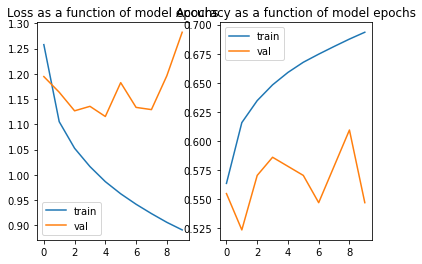

In [27]:
plt.subplot(1,2,1)
plt.plot(results.history["loss"])
plt.plot(results.history["val_loss"])
plt.legend(labels=["train", "val"])
plt.title("Loss as a function of model epochs")

plt.subplot(1,2,2)
plt.plot(results.history["categorical_accuracy"])
plt.plot(results.history["val_categorical_accuracy"])
plt.legend(labels=["train", "val"])
plt.title("Accuracy as a function of model epochs")
plt.show()

## Question 3

### Part 1: RNN - character-level

In [28]:
df = pd.read_csv('SPAM_detection.csv')
df.head()

,Message,category_val
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [29]:
import re
import string
import spacy
from sklearn.model_selection import train_test_split
from spacy.lang.en import English
from sklearn.feature_extraction.text import CountVectorizer
from scipy import sparse

stop_words = spacy.lang.en.stop_words.STOP_WORDS
punctuations = string.punctuation

nlp = English()
# Create a Tokenizer with the default settings for English
# including punctuation rules and exceptions
tokenizer = nlp.Defaults.create_tokenizer(nlp)

In [30]:
def custom_tokenizer(x):
    # tokenize raw text
    tokened = tokenizer(x)
    
    # lemmatize token and lower case
    tokened_lemma = [ word.lemma_.lower().strip() if word.lemma_ != "-PROPN-" 
                     else word.lower_ 
                     for word in tokened ]
    
    # remove punctuation
    # remove stop words
    tokened_lemma_nostop = [ re.sub(r'[^\w\s]','',word)  for word in tokened_lemma 
                     if word not in stop_words and word not in punctuations]
    
    return tokened_lemma_nostop

In [31]:
df['processed_message'] = df['Message'].apply(lambda x: custom_tokenizer(x))
max_len_message = 20 #df['processed_message'].apply(lambda x: len(x)).max()

In [32]:
combined_text = ''
for i in df['Message'].to_numpy():
    combined_text += ' ' + i
processed_text = custom_tokenizer(combined_text)

In [33]:
#vocab = np.unique(processed_text)
#vocab_indices = dict((c, i) for i, c in enumerate(vocab))
#x_matrix = sparse.csr_matrix.toarray(count_results)

In [34]:
# I tried to use one hot encoding for every word but that didn't seem to work

# X = np.zeros((len(df), max_len_message, len(vocab)), dtype=np.uint8 )
# for i, seq in enumerate(df['processed_message']):
#     for t, word in enumerate(seq):
#         try:
#             word_num = vocab_indices[re.sub(r'[^\w\s]', '', word)]
#         except:
#             word_num = vocab_indices[word]
#         X[i, t, word_num] = 1

# instead I set up sequences to pass into the model to then go through word embedding
# this also didn't work for some reason. My janky tokenizing didn't work properly.

# X = np.zeros((len(df), max_len_message), dtype=np.uint8 )
# for i, seq in enumerate(df['processed_message']):
#     for t, word in enumerate(seq[:max_len_message]):
#         try:
#             word_num = vocab_indices[re.sub(r'[^\w\s]', '', word)]
#         except:
#             word_num = vocab_indices[word]
#         X[i, t] = word_num

In [35]:
# So now let's use keras instead, with slightly better but still not amazing results
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

keras_tokenizer = Tokenizer()
keras_tokenizer.fit_on_texts(df['Message'].values)
vocab = keras_tokenizer.index_word
X = keras_tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X, maxlen=max_len_message, padding='post')

Using TensorFlow backend.


In [36]:
# split the data into three categories: train section for training model, 
# validation section for checking progress at each epoch
# and test section for checking final performance of model
X_train, X_test, y_train, y_test \
    = train_test_split([x for x in range(X.shape[0])], 
                       df['category_val'].values, 
                       test_size=0.2, 
                       random_state=56416,
                       stratify = df['category_val'].values)

X_train, X_val, y_train, y_val \
    = train_test_split([x for x in range(len(X_train))], 
                       y_train, 
                       test_size=0.1, 
                       random_state=764,
                       stratify = y_train)


In [37]:
train_tfdf = (  tf.data.Dataset.from_tensor_slices(
                   (tf.cast(X[X_train,:], tf.uint32), tf.cast(y_train, tf.uint8))
                )
             .batch(64).repeat()
             )
test_tfdf = (  tf.data.Dataset.from_tensor_slices(
                   (tf.cast(X[X_test,:], tf.uint32), tf.cast(y_test, tf.uint8))
                )
             )
val_tfdf = (  tf.data.Dataset.from_tensor_slices(
                   (tf.cast(X[X_val,:], tf.uint32), tf.cast(y_val, tf.uint8))
                )
             .batch(len(y_val)).repeat()
             )

#### Models

In [38]:
rnn_model = tfk.Sequential([
    tfkl.Embedding(input_dim=len(vocab), output_dim=16, input_length=max_len_message),
    tfkl.LSTM(40),
    tfkl.Dropout(0.25),
    tfkl.Dense(1,activation="sigmoid")
])
rnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 16)            144064    
_________________________________________________________________
lstm (LSTM)                  (None, 40)                9120      
_________________________________________________________________
dropout_8 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 41        
Total params: 153,225
Trainable params: 153,225
Non-trainable params: 0
_________________________________________________________________


In [39]:
rnn_model.compile(loss=tfk.losses.BinaryCrossentropy(), 
                  metrics=[tfk.metrics.BinaryAccuracy()],
                  optimizer=tfk.optimizers.Adam()
                 )
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [40]:
results = rnn_model.fit(train_tfdf, steps_per_epoch=2000, epochs=20, 
                          validation_data = val_tfdf,
                          validation_steps = 1,
          callbacks=[tensorboard_callback])

Epoch 1/20
   2/2000 [..............................] - ETA: 2:16 - loss: 0.6930 - binary_accuracy: 0.5156WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0051s vs `on_train_batch_end` time: 0.1306s). Check your callbacks.


2000/2000 [==============================] - 7s 4ms/step - loss: 0.1161 - binary_accuracy: 0.9544 - val_loss: 1.5781 - val_binary_accuracy: 0.7332
Epoch 2/20
2000/2000 [==============================] - 7s 4ms/step - loss: 0.0396 - binary_accuracy: 0.9793 - val_loss: 1.6868 - val_binary_accuracy: 0.7646
Epoch 3/20
2000/2000 [==============================] - 7s 4ms/step - loss: 0.0350 - binary_accuracy: 0.9807 - val_loss: 1.6317 - val_binary_accuracy: 0.7870
Epoch 4/20
2000/2000 [==============================] - 7s 4ms/step - loss: 0.0324 - binary_accuracy: 0.9813 - val_loss: 2.0208 - val_binary_accuracy: 0.7735
Epoch 5/20
2000/2000 [==============================] - 7s 4ms/step - loss: 0.0317 - binary_accuracy: 0.9816 - val_loss: 2.1903 - val_binary_accuracy: 0.7713
Epoch 6/20
2000/2000 [==============================] - 7s 4ms/step - loss: 0.0303 - binary_accuracy: 0.9817 - val_loss: 2.3047 - val_binary_accuracy: 0.7691
Epoch 7/20
2000/2000 [==============================] - 7s 4ms/

#### Model performance

In [41]:
y_pred_keras = rnn_model.predict(X[X_test,:]).ravel()
fpr_keras_rnn, tpr_keras_rnn, thresholds_keras_rnn = roc_curve(y_test, y_pred_keras)
auc_keras_rnn = auc(fpr_keras_rnn, tpr_keras_rnn)

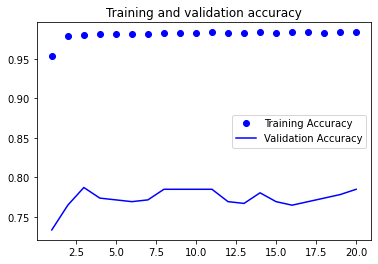

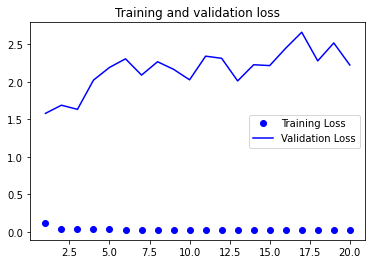

In [42]:
acc = results.history['binary_accuracy']
val_acc = results.history['val_binary_accuracy']
loss = results.history['loss']
val_loss = results.history['val_loss']

# Training + Valdiation Accuracy
epochs = range(1,len(acc) + 1)
plt.plot( epochs, acc, 'bo', label = 'Training Accuracy')
plt.plot( epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# Training + Validation Loss
plt.plot( epochs, loss, 'bo', label = 'Training Loss')
plt.plot( epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### 3.2 CNN

Text(0.5, 1.0, 'Character length distribution')

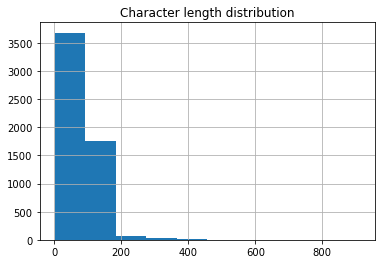

In [43]:
df.Message.str.len().hist()
plt.title('Character length distribution')

In [44]:
max_char = 400

char_tokenizer = Tokenizer(char_level = True)
char_tokenizer.fit_on_texts(df['Message'].values)
vocab = char_tokenizer.index_word
X = char_tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X, maxlen=max_char, padding='post')

In [45]:
train_tfdf = (  tf.data.Dataset.from_tensor_slices(
                   (tf.cast(X[X_train,:], tf.uint32), tf.cast(y_train, tf.uint8))
                )
             .batch(64).repeat()
             )
test_tfdf = (  tf.data.Dataset.from_tensor_slices(
                   (tf.cast(X[X_test,:], tf.uint32), tf.cast(y_test, tf.uint8))
                )
             )
val_tfdf = (  tf.data.Dataset.from_tensor_slices(
                   (tf.cast(X[X_val,:], tf.uint32), tf.cast(y_val, tf.uint8))
                )
             .batch(len(y_val)).repeat()
             )

In [46]:
input_model = tfkl.Input(shape=(400))
embedding_layer = tfkl.Embedding(input_dim=len(vocab), output_dim=8, input_length=max_char)(input_model)

conv_model1 = tfk.Sequential([
        tfkl.Conv1D(256, kernel_size = 2, strides = 1, padding = 'same', activation = 'relu'),
        tfkl.AveragePooling1D(400),
        tfkl.Dropout(0.3),
])(embedding_layer)
conv_model2 = tfk.Sequential([
        tfkl.Conv1D(256, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'),
        tfkl.AveragePooling1D(400),
        tfkl.Dropout(0.3),
])(embedding_layer)
conv_model3 = tfk.Sequential([
        tfkl.Conv1D(256, kernel_size = 4, strides = 1, padding = 'same', activation = 'relu'),
        tfkl.AveragePooling1D(400),
        tfkl.Dropout(0.3),
])(embedding_layer)
conv_model4 = tfk.Sequential([
        tfkl.Conv1D(256, kernel_size = 5, strides = 1, padding = 'same', activation = 'relu'),
        tfkl.AveragePooling1D(400),
        tfkl.Dropout(0.3),
])(embedding_layer)

combined_model = tfkl.concatenate([conv_model1, conv_model2, conv_model3, conv_model4], axis = -1)
combined_model = tfkl.Flatten()(combined_model)
combined_model = tfkl.Dense(300,activation="relu")(combined_model)
combined_model = tfkl.LayerNormalization()(combined_model)
combined_model = tfkl.Dropout(0.3)(combined_model)
combined_model = tfkl.Dense(300,activation="relu")(combined_model)
combined_model = tfkl.LayerNormalization()(combined_model)
combined_model = tfkl.Dropout(0.3)(combined_model)
combined_model = tfkl.Dense(300,activation="relu")(combined_model)
combined_model = tfkl.LayerNormalization()(combined_model)
combined_model = tfkl.Dropout(0.3)(combined_model)
combined_model = tfkl.Dense(1,activation="sigmoid")(combined_model)

char_model = tfk.Model(input_model, combined_model)
char_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 400)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 8)       720         input_5[0][0]                    
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 1, 256)       4352        embedding_1[0][0]                
__________________________________________________________________________________________________
sequential_6 (Sequential)       (None, 1, 256)       6400        embedding_1[0][0]                
_______________________________________________________________________________________

In [47]:
char_model.compile(loss=tfk.losses.BinaryCrossentropy(), 
                  metrics=[tfk.metrics.BinaryAccuracy()],
                  optimizer=tfk.optimizers.Adam()
                 )
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [48]:
results = char_model.fit(train_tfdf, steps_per_epoch=1000, epochs=10, 
                          validation_data = val_tfdf,
                          validation_steps = 1,
          callbacks=[tensorboard_callback])

Epoch 1/10
   2/1000 [..............................] - ETA: 55s - loss: 1.0458 - binary_accuracy: 0.6016WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0116s vs `on_train_batch_end` time: 0.0988s). Check your callbacks.


1000/1000 [==============================] - 11s 11ms/step - loss: 0.4094 - binary_accuracy: 0.8640 - val_loss: 0.3950 - val_binary_accuracy: 0.8655
Epoch 2/10
1000/1000 [==============================] - 11s 11ms/step - loss: 0.3980 - binary_accuracy: 0.8658 - val_loss: 0.3949 - val_binary_accuracy: 0.8655
Epoch 3/10
1000/1000 [==============================] - 11s 11ms/step - loss: 0.3961 - binary_accuracy: 0.8660 - val_loss: 0.3951 - val_binary_accuracy: 0.8655
Epoch 4/10
1000/1000 [==============================] - 11s 11ms/step - loss: 0.3963 - binary_accuracy: 0.8658 - val_loss: 0.3966 - val_binary_accuracy: 0.8655
Epoch 5/10
1000/1000 [==============================] - 11s 11ms/step - loss: 0.3958 - binary_accuracy: 0.8658 - val_loss: 0.3952 - val_binary_accuracy: 0.8655
Epoch 6/10
1000/1000 [==============================] - 11s 11ms/step - loss: 0.3950 - binary_accuracy: 0.8660 - val_loss: 0.3950 - val_binary_accuracy: 0.8655
Epoch 7/10
1000/1000 [=============================

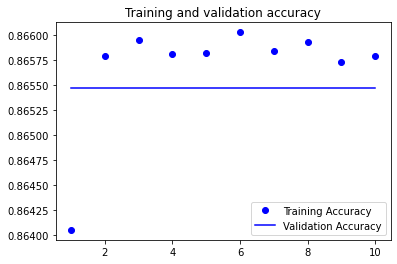

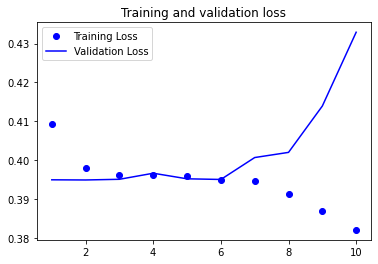

In [49]:
acc = results.history['binary_accuracy']
val_acc = results.history['val_binary_accuracy']
loss = results.history['loss']
val_loss = results.history['val_loss']

# Training + Valdiation Accuracy
epochs = range(1,len(acc) + 1)
plt.plot( epochs, acc, 'bo', label = 'Training Accuracy')
plt.plot( epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# Training + Validation Loss
plt.plot( epochs, loss, 'bo', label = 'Training Loss')
plt.plot( epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### 3.3 ROC Curve

In [50]:
y_pred_keras = rnn_model.predict(X[X_test,:]).ravel()
fpr_keras_cnn, tpr_keras_cnn, thresholds_keras_cnn = roc_curve(y_test, y_pred_keras)
auc_keras_cnn = auc(fpr_keras_cnn, tpr_keras_cnn)

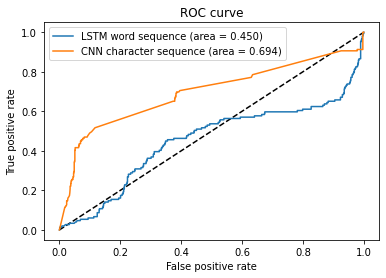

In [51]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras_rnn, tpr_keras_rnn, label='LSTM word sequence (area = {:.3f})'.format(auc_keras_rnn))
plt.plot(fpr_keras_cnn, tpr_keras_cnn, label='CNN character sequence (area = {:.3f})'.format(auc_keras_cnn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()